In [1]:
#import seaborn as sns
import numpy as np
import pandas as pd
import dtale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
%matplotlib inline

In [2]:
df = pd.read_csv('churndata.csv', low_memory=False)

## EDA
The EDA is the first step of our machine learning modeling. It's gonna composed of 3 subsections. First of all we're going to take a look at the structure of our dataset in order to insight about our variable. This first subsection will help us to know different type of the variables and the shape of the dataset, to check variables with missing values. After we are going the feature engineering and feature transformation task where we correct type of some variables, treat missing values,tansform and normalize variables.

In [3]:
print(list(df.columns))

print '\n The shape of the dataset:  ',df.shape

['account_id', 'account_number', 'status', 'arrhes_day', 'price_program', 'arrhes', 'total_amount', 'minimum_payment', 'gap', 'invoce_model', 'created_at', 'total_payed', 'next_payment', 'balance', 'group_name', 'prev_payment', 'prev_account_number', 'slug', 'cutoff_days', 'register_by', 'day_disabled', 'written_off', 'written_off_at', 'expected_total_amount', 'repossessed_at', 'id_tenant', 'commune', 'region']

 The shape of the dataset:   (63918, 28)


### Numerical variables overview

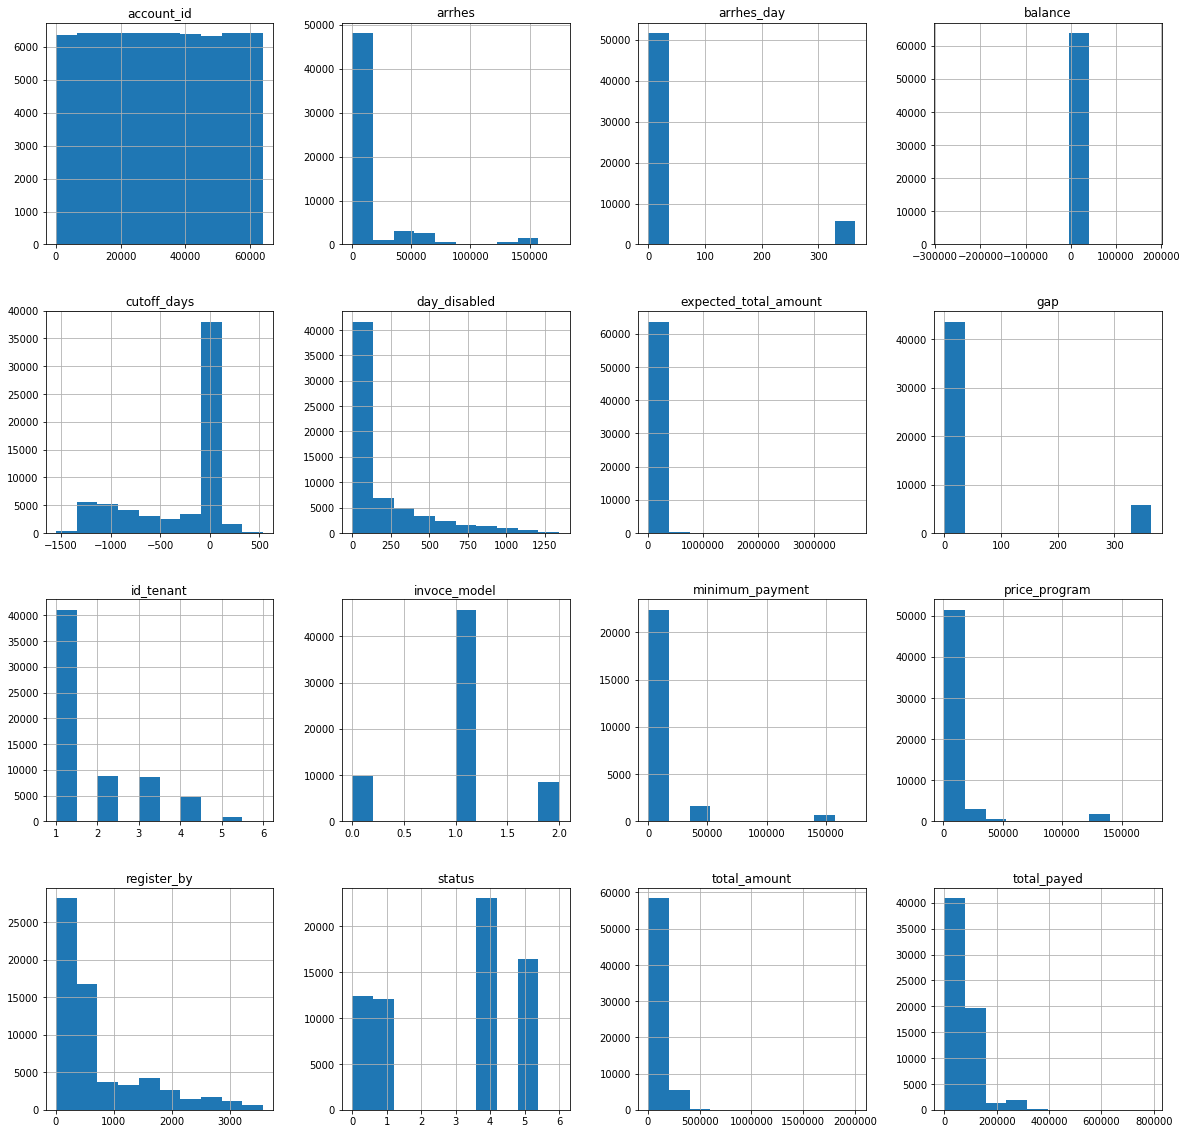

In [4]:
# Nuemerical overview
var_num = [var for var in df.columns if df[var].dtypes in('float64','int64')]
df[var_num].hist(figsize=(20,20))
plt.show()

From these histograms we can see that the account_id is almost uniformly distributed and that can justify that they are Id for observations.The account_number and previous_account number have almost the same probability distribution. Some feature here are also redondant for gap, arrhes_day and register_by and user_id and total_amount and expected_total_amount. We notice that few feature here countinous variable which are total_amount, expected_amount_paid, total_payed, day_disabled, cutoff_days and the emaining numerical variable are discret. The day_disabled and the total_payed feature are right skew, so some normalization technics must be applied to them.

### Missing valuesoverview

In [5]:
# Let's make the list of variables that contains missing values
var_na = [var for var in df.columns if df[var].isnull().sum()>1]
# Let's show the variable and the percentage of missing values
for var in var_na:
    print var, np.round(100*df[var].isnull().mean(),3), '% missing values'

account_number 25.669 % missing values
arrhes_day 10.268 % missing values
price_program 10.549 % missing values
arrhes 10.268 % missing values
minimum_payment 61.239 % missing values
gap 22.668 % missing values
next_payment 35.918 % missing values
prev_payment 1.112 % missing values
prev_account_number 63.475 % missing values
written_off_at 62.172 % missing values
repossessed_at 87.848 % missing values


We find that there 11 columns with missing values. 4 of them are date features. Usually dates are not predictive but we can use them to compute period or age features which will be predictive. We gonna remove the next_payment and the repossessed_at date because the first one is used to compute the cutoff_days dispite it has few missing values and the second has almost 90% missing values and written_off_at too. for the prev_payment where we only miss 1.112% of the observations, we gonna replace the missing values by the created_at date and used it to create a new columns that give the #days since last payment. The gap could create redondancy with the harres feature. The missing values of account_number and prev_account_number can be explained by the repossession and replacement of the system. thefore we can deal with those to columns to to check wether this was a replacement or not in a account and after we should remove them.

In [6]:
num_variables = [var for var in df.columns if df[var].dtypes !='O']
none_num = df.shape[1]-len(num_variables)
print 'there are %(num_var)d numerical variables and %(none_num)d none numerical in the data set ' %{"num_var":len(num_variables),"none_num":none_num}

there are 17 numerical variables and 11 none numerical in the data set 


### Univariate & Bivariate Analysis

In [7]:
d = dtale.show(df)

In [8]:
d

## Data Preparation

In [9]:
df = df.drop(['next_payment','gap','minimum_payment','written_off_at','repossessed_at','register_by'], axis = 1)

In [10]:
df['prev_payment']= df['prev_payment'].fillna(df['created_at'])

In [11]:
df['replacement'] = ~df['account_number'].isnull() & ~df['prev_account_number'].isnull()
df = df.drop(['account_number','prev_account_number'], axis = 1)

In [12]:
df['created_at'] = pd.to_datetime(df['created_at'],errors='ignore')
df['prev_payment'] = pd.to_datetime(df['prev_payment'],errors='ignore')

In [13]:
#Let's set up the date we got the inputs (27/08/2019) to compute the Age of the customer account in month
today= pd.to_datetime('2020-10-16')
#fix_date = datetime.strptime(fix_date,'%Y-%m-%d')
df['AccountAge'] = (today - df['created_at'])/np.timedelta64(1,'M')
# Let's compute the number of days since the previous payment 
#and the days between the last and the next payment
df['SinceLastPay'] = (today - df['prev_payment'])/np.timedelta64(1,'D')

df = df.drop(['created_at','prev_payment'], axis = 1)

In [14]:
#For arrhes_day,arrhes and price_program we can be explained by the group_name so we can delete them
df = df.drop(['arrhes_day','arrhes','price_program'], axis=1)

In [15]:
df['locality'] = df['commune'].map(str)+'-'+df['region'].map(str)
df = df.drop(['region','commune'], axis=1)

In [16]:
Id = df[['account_id','slug']]

data = df.drop(['account_id','slug'], axis=1)
data = pd.get_dummies(data, drop_first= True)

In [17]:
print data.shape
data.head()

(63918, 1450)


,status,total_amount,invoce_model,total_payed,balance,cutoff_days,day_disabled,written_off,expected_total_amount,id_tenant,...,locality_ZECCO-Nahouri,locality_ZEGOUA-KADIOLO,locality_ZIGUINCHOR-NIAGUIS-ZIGUINCHOR,locality_ZIGUINCHOR-ZIGUINCHOR,locality_ZINIARE-Oubritenga,locality_ZIOU-Nahouri,locality_ZITENGA-Oubritenga,locality_ZOAGA-Boulgou,locality_ZONSE-Boulgou,locality_ZORGHO-Ganzourgou
0,4,39000,2,39000,0,0.0,1,False,39000,3,...,0,0,0,0,0,0,0,0,0,0
1,0,126000,1,75650,0,27.0,671,False,126000,1,...,0,0,0,0,0,0,0,0,0,0
2,4,39000,2,39000,0,0.0,1,False,39000,3,...,0,0,0,0,0,0,0,0,0,0
3,5,52500,1,0,0,0.0,0,False,52500,3,...,0,0,0,0,0,0,0,0,0,0
4,4,255000,2,255000,0,0.0,0,False,255000,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
var_num = [var for var in data.columns if data[var].dtypes in('float64','int64')]
skew_var = data[var_num].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skew_var})

In [20]:
skewness

,Skew
expected_total_amount,9.882838
total_amount,3.151942
day_disabled,1.843320
total_payed,1.590846
id_tenant,1.337857
SinceLastPay,0.766509
invoce_model,-0.018405
status,-0.434372
AccountAge,-0.469946
cutoff_days,-1.032962


In [21]:
data.corr()

,status,total_amount,invoce_model,total_payed,balance,cutoff_days,day_disabled,written_off,expected_total_amount,id_tenant,...,locality_ZECCO-Nahouri,locality_ZEGOUA-KADIOLO,locality_ZIGUINCHOR-NIAGUIS-ZIGUINCHOR,locality_ZIGUINCHOR-ZIGUINCHOR,locality_ZINIARE-Oubritenga,locality_ZIOU-Nahouri,locality_ZITENGA-Oubritenga,locality_ZOAGA-Boulgou,locality_ZONSE-Boulgou,locality_ZORGHO-Ganzourgou
status,1.000000,-0.206887,0.190895,-0.191961,-0.008578,-0.464972,-0.313453,0.348612,-0.189882,-0.120857,...,-0.004335,0.010860,-0.008670,-0.001139,-0.010278,-0.005848,-0.002593,-0.005848,-0.001044,0.002181
total_amount,-0.206887,1.000000,-0.269400,0.607418,-0.016529,-0.024660,0.012747,0.024611,0.913656,-0.281937,...,0.002566,-0.016132,0.010160,0.003994,0.015662,0.011912,-0.003898,0.010474,0.009964,-0.001865
invoce_model,0.190895,-0.269400,1.000000,-0.085589,0.002728,0.119401,-0.133928,-0.162360,-0.246668,0.216550,...,-0.004035,0.010496,0.002633,0.008126,-0.004761,0.000142,-0.010284,-0.007272,0.000512,0.000142
total_payed,-0.191961,0.607418,-0.085589,1.000000,-0.008288,0.537201,-0.169279,-0.519829,0.560675,-0.070948,...,0.002657,0.004032,0.004643,0.016265,0.029709,0.006115,-0.001380,0.005456,0.015676,0.001201
balance,-0.008578,-0.016529,0.002728,-0.008288,1.000000,-0.015012,0.007819,0.012076,-0.016114,-0.010321,...,0.000211,0.000333,0.000421,0.000608,0.000927,0.000122,0.000172,0.000122,0.000439,0.000122
cutoff_days,-0.464972,-0.024660,0.119401,0.537201,-0.015012,1.000000,-0.219483,-0.893775,-0.016607,0.380378,...,0.003981,0.019377,0.010685,0.010050,0.019069,0.002597,0.005457,0.005112,0.009952,0.002563
day_disabled,-0.313453,0.012747,-0.133928,-0.169279,0.007819,-0.219483,1.000000,0.383848,0.007913,-0.272605,...,-0.003471,-0.015256,-0.008735,-0.001724,-0.013325,-0.002624,-0.003700,-0.002624,-0.008292,-0.002249
written_off,0.348612,0.024611,-0.162360,-0.519829,0.012076,-0.893775,0.383848,1.000000,0.016820,-0.352580,...,-0.005098,-0.021330,-0.010196,-0.009762,-0.019169,-0.002943,-0.004162,-0.002943,-0.010612,-0.002943
expected_total_amount,-0.189882,0.913656,-0.246668,0.560675,-0.016114,-0.016607,0.007913,0.016820,1.000000,-0.252513,...,0.002245,-0.015096,0.009146,0.004092,0.013944,0.010774,-0.003612,0.009467,0.008934,-0.001744
id_tenant,-0.120857,-0.281937,0.216550,-0.070948,-0.010321,0.380378,-0.272605,-0.352580,-0.252513,1.000000,...,0.015279,0.010791,-0.008934,-0.012897,0.067209,0.008821,0.012475,0.008821,0.031807,0.008821


Executing shutdown due to inactivity...


2020-10-16 22:03:52,217 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2020-10-16 22:03:53,370 - INFO     - Executing shutdown...
